# Solución etapa 4 - Training - Predict

In [ ]:
# Utilidades para print
from utils.print_utils import tabl, headr, titl
from utils.explore_utils import explr

In [ ]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skforecast.recursive import ForecasterRecursive
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from skforecast.model_selection import backtesting_forecaster
from skforecast.datasets import fetch_dataset
from skforecast.model_selection import TimeSeriesFold

In [ ]:
version_to_load='v1'

In [ ]:
# Cargar el dataset
csv_path = f'../data/preprocessed/preprocessed_data_{version_to_load}.csv'
print('... Loading:', csv_path,'...')
final_data = pd.read_csv(csv_path)

tabl(final_data)

In [ ]:
final_data.info()

In [ ]:
# Preparación del dato

final_data['Fecha'] = pd.to_datetime(final_data['Fecha'], format='%Y-%m-%d')


In [ ]:
target_column = 'Fallo'

## Extraemos un equipo

In [101]:
equipo = final_data[final_data['ID_Equipo'] == 2]

In [102]:
# Eliminar columnas innecesarias
equipo.drop(columns=['ID_Equipo'], inplace=True)

C:\Users\ricar\AppData\Local\Temp\ipykernel_11760\1548657718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equipo.drop(columns=['ID_Equipo'], inplace=True)


In [103]:
# fecha como índice
equipo = equipo.set_index('Fecha')

In [104]:
# ïndices Duplicados
equipo[equipo.index.duplicated()]

,Horas_Operativas,Fallo,Tipo_Equipo,Fabricante,Potencia_kW,Horas_Recomendadas_Revision
Fecha,,,,,,
2024-10-13,10,1.0,Generador,Fabricante_B,393,522


In [105]:
# Eliminar índices duplicados (mantener el primero)
equipo_clean = equipo[~equipo.index.duplicated(keep='first')]

equipo_clean[equipo_clean.index.duplicated()]

,Horas_Operativas,Fallo,Tipo_Equipo,Fabricante,Potencia_kW,Horas_Recomendadas_Revision
Fecha,,,,,,


In [106]:
# Convierte Timeseries a frecuencia especificada.
equipo_fq = equipo_clean.asfreq('D') 
equipo_fq = equipo_clean.sort_index()
equipo_fq.head()

,Horas_Operativas,Fallo,Tipo_Equipo,Fabricante,Potencia_kW,Horas_Recomendadas_Revision
Fecha,,,,,,
2021-01-01,708,0.0,Generador,Fabricante_B,393,522
2021-01-02,721,0.0,Generador,Fabricante_B,393,522
2021-01-03,737,0.0,Generador,Fabricante_B,393,522
2021-01-04,758,0.0,Generador,Fabricante_B,393,522
2021-01-05,779,0.0,Generador,Fabricante_B,393,522


In [107]:
# Verificar que un índice temporal está completo

fecha_inicio = equipo_fq.index.min()
fecha_fin = equipo_fq.index.max()
date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=equipo_fq.index.freq)

print(f"Índice completo: {(equipo_fq.index == date_range_completo).all()}")

Índice completo: True


## Separación datos train-test

Fechas train : 2021-01-01 00:00:00 --- 2024-12-01 00:00:00  (n=1431)
Fechas test  : 2024-12-02 00:00:00 --- 2024-12-31 00:00:00  (n=30)


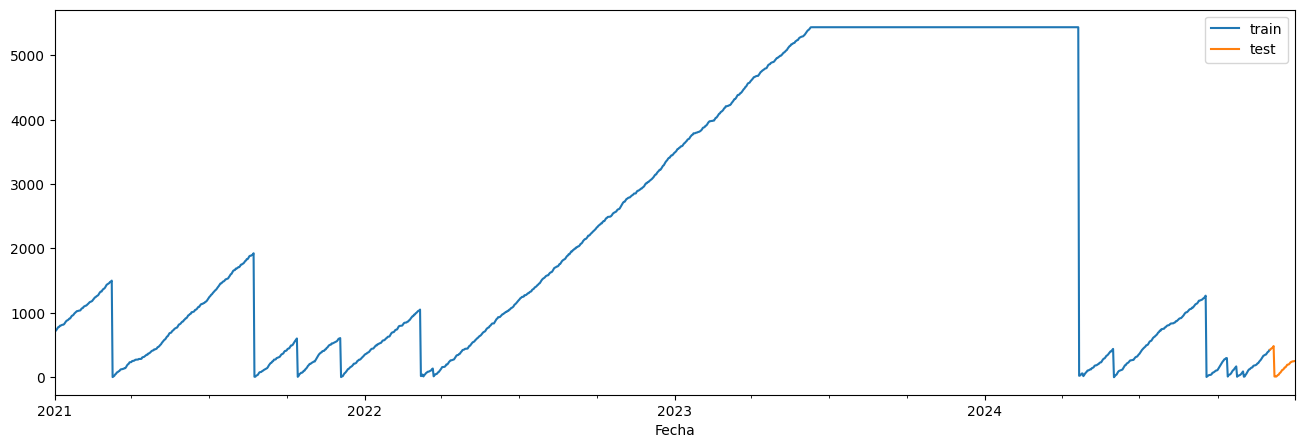

In [108]:
steps = 30
datos_train = equipo_fq[:-steps]
datos_test  = equipo_fq[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(16, 5))
datos_train['Horas_Operativas'].plot(ax=ax, label='train')
datos_test['Horas_Operativas'].plot(ax=ax, label='test')
ax.legend();